In [1]:
# All import statements

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from random import sample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import copy

In [2]:
#Create data for classification and split it into train and test samples
x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

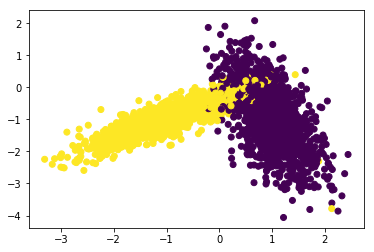

In [3]:
%matplotlib inline
colors = {0:'red', 1:'blue'}
plt.scatter(X_test[:,0], X_test[:,1],c=y_test)
plt.show()

## Implementation of RandomSearchCV

In [4]:
# Golbal variables
TrainScores = []
TestScores = []
hyper_parameters = []
Best_Accuracy_k = 0

def RandomSearchCV(X_train, y_train, classifier, param_range, folds):    
    
    testscores_folds = []
    trainscores_folds = []
    
    testscores = []
    trainscores = []
    
    end = len(X_train)
                
    # initializing values for sub data groups
    x_train1 = 0 
    x_train2 = 0
    y_train1 = 0
    y_train2 = 0
    
    # creates 10 different values for k
    hyper_parameters = sorted(list(sample(range(param_range[0], param_range[1]), 10)))
    
    # For each random hyper-parameter
    for k in hyper_parameters:
        
        # making sure group size doesn't change after each iteration of 'k'
        group_size = int(len(X_train)/folds)
        
        for i in range(folds):
            
            # This if-else ladder makes calculation for train-test data indices
            if i == 0:
                x_train1 = 0 
                x_train2 = end-group_size
                y_train1 = end-group_size
                y_train2 = end
                x_train3 = 0
                x_train4 = 0
                
            elif i == folds-1:
                y_train1 = 0
                y_train2 = group_size
                x_train1 = group_size
                x_train2 = end
                x_train3 = 0
                x_train4 = 0
                
            else:
                x_train1 = 0
                x_train2 = group_size*i
                y_train1 = group_size*i
                y_train2 = group_size*i+group_size
                x_train3 = group_size*i+group_size 
                x_train4 = end
            
            # changing k for each hyper parameter
            classifier.n_neighbors = k
            
            # if-else to create array for classification
            if x_train3 == 0 and x_train4 == 0:
                X_train_classifier = X_train[x_train1:x_train2]
                y_train_classifier = y_train[x_train1:x_train2]
            else:
                X_train_classifier = np.append(X_train[x_train1:x_train2],X_train[x_train3:x_train4], axis=0)
                y_train_classifier = np.append(y_train[x_train1:x_train2],y_train[x_train3:x_train4], axis=0)
            
            # printing the shape of the data for the very first value of hyper-parameter
            if k == hyper_parameters[0] and i == 0:
                print ("Shape - X_train: {0}, y_train: {0}".format(X_train_classifier.shape, y_train_classifier.shape))
            
            # classier fit function call with data-set variables
            classifier.fit(X_train_classifier, y_train_classifier)
                
            # Finding train accuracy
            Y_predicted = classifier.predict(X_train_classifier)
            trainscores_folds.append(accuracy_score(y_train_classifier, Y_predicted))
            
            # Finding CV accuracy
            Y_predicted = classifier.predict(X_train[y_train1:y_train2])
            testscores_folds.append(accuracy_score(y_train[y_train1:y_train2], Y_predicted))
            
        # Append average accuracy
        trainscores.append(np.mean(np.array(trainscores_folds))*100)
        testscores.append(np.mean(np.array(testscores_folds))*100)
                
    # Returning hyper parameters as they will be generated randomly each time so I'll need a record of each unique generation
    return trainscores, testscores, hyper_parameters

if __name__ == "__main__":
    
    # Tuple initiating random values
    param_range = (1, 50)
    kNN = KNeighborsClassifier()
    folds = 5
    
    # creating x_train, y_train, x_test and y_test
    TrainScores, TestScores, hyper_parameters = RandomSearchCV(X_train, y_train, kNN, param_range, folds)
    
    # Print Accuracies with Hyper Parameter
    print ("Hyper Paramter and Train Scores")
    for i, k in zip(TrainScores, hyper_parameters):
        print (k,"\t", i)
    print ("\n\nHyper Paramter and Test Scores")
    for i, k in zip(TestScores, hyper_parameters):
        print (k,"\t", i)
    
    # Finding best hyper parameter based on test dataset
    zippedList = zip(TestScores, hyper_parameters)
    zippedList = sorted(zippedList, key=lambda element:element[0], reverse=True)
    Best_Accuracy_k = zippedList[0][1]

Shape - X_train: (6000, 2), y_train: (6000, 2)
Hyper Paramter and Train Scores
3 	 96.75666666666667
11 	 96.33333333333333
18 	 96.15555555555557
19 	 96.065
22 	 95.99933333333334
25 	 95.955
28 	 95.92095238095239
41 	 95.89666666666666
43 	 95.88111111111108
49 	 95.87033333333333


Hyper Paramter and Test Scores
3 	 94.74666666666668
11 	 95.04666666666667
18 	 95.15555555555557
19 	 95.21
22 	 95.25866666666666
25 	 95.29111111111112
28 	 95.31619047619047
41 	 95.34666666666666
43 	 95.37185185185186
49 	 95.40266666666669


In [5]:
print ("Hyper Parameter with best accuracy - ", Best_Accuracy_k)

Hyper Parameter with best accuracy -  49


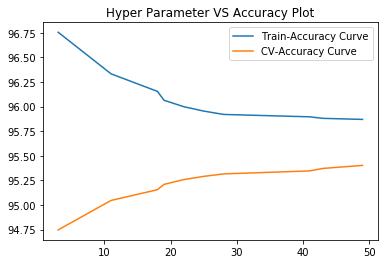

In [6]:
plt.plot(hyper_parameters,TrainScores, label='Train-Accuracy Curve')
plt.plot(hyper_parameters,TestScores, label='CV-Accuracy Curve')
plt.title('Hyper Parameter VS Accuracy Plot')
plt.legend(loc="best")
plt.show()

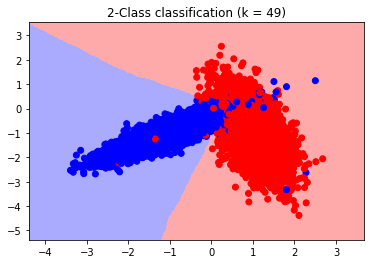

In [7]:
def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()
    
    
    
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = Best_Accuracy_k)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)